**Find the ground state energy of a certain Hamiltonian with SDP:**
1. We can somehow prepare the groud state $\rho_g$ of a Hamiltonian $H$
2. We do quantum tomography on this prepared state $\rho_g$ and get an approximation $\hat{\rho}$
3. By using SDP, we get a physically valid quantum state $\hat{\rho}_{SDP}$ which minimizes $\text{Tr}(\rho H)$ for $\rho \in \tilde{\rho}$
4. The ground state energy we find is then $\text{Tr}(H\hat{\rho}_{SDP})$

In [1]:
import argparse
import time
import random
import itertools
import numpy as np
import cvxpy as cp
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli, partial_trace, state_fidelity, random_density_matrix
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.monitor import job_monitor
import os
#os.environ["OMP_NUM_THREADS"] = "10"

# Generate measurement dataset
def meas(qubits_meas_basis, state, num_meas, N):
    ''' Given a Pauli basis (0-Z, 1-X, 2-Y), do measurement and return its outcome
    Args:
        qubits_meas_basis: A list representing measuring basis, e.g.: [0,0,0] is 'ZZZ'
        state: A quantum state from Qiskit
        num_meas: number of measurements performed in this basis
    Yeilds:
        outcome: A list of strings, of which each element is an instance of measurement
    E.g.:
        INPUT: [0,0,0], state, N=3, num_meas=2
        OUTPUT: [000, 000] (in order of qubit 012)
    '''
    outcome = []
    circ_meas = QuantumCircuit(N)

    if num_meas>0:
        for i in range(N):
            if qubits_meas_basis[i] == '1':
                circ_meas.ry(-math.pi / 2, i)
            elif qubits_meas_basis[i] == '2':
                circ_meas.rx(math.pi / 2, i)

        U_meas = Operator(circ_meas)
        state_temp = state.evolve(U_meas)
        for j in range(num_meas):
            str_tmp = state_temp.measure()[0]
            outcome.append(str_tmp[::-1])  # Take the reverse

    # Note: in qiskit, qubit number counts from the left,
    # e.g.: '00101' means we measure qubit0 a '1'.
    return outcome
def number_to_Pauli(pauli_num_str, N):
    ''' Given a number string, return the corresponding Pauli string
        0-Z, 1-X, 2-Y
    E.g.:
        INPUT: '01200' (in order of qubit 01234)
        OUTPUT: 'ZZYXZ' (in order of qubit 01234)
    '''
    pauli_num_list = list(pauli_num_str)
    pauli_basis_list = list(pauli_num_str)
    for i in range(N):
        if pauli_num_list[i] == '1':
            pauli_basis_list[i] = 'X'
        elif pauli_num_list[i] == '2':
            pauli_basis_list[i] = 'Y'
        else:
            pauli_basis_list[i] = 'Z'
    return ''.join(pauli_basis_list)
def random_distribute(N_meas, N):
    '''N_meas is the total number of measurements for all basis
    '''
    quotient = N_meas//3**N
    remainder = N_meas%3**N
    num_of_meas_list = quotient*np.ones(3**N)
    
    tmp = list(range(0,3**N))
    lucky_dog = random.sample(tmp, int(remainder))

    for i in range(remainder):
        num_of_meas_list[lucky_dog[i]] = num_of_meas_list[lucky_dog[i]]+1

    return num_of_meas_list
def generate_meas_dataset(state, N_meas, N):
    '''Generate measurement dataset for a N-qubit quantum state
    Args:
        state: A quantum state from Qiskit
        N_meas: total number of measurements for all basis
        N: number of qubits of the state
    Yeilds:
        Dict_meas_outcome
    '''
    Dict_meas_outcome = dict()
    num_meas_list = random_distribute(N_meas, N) # A list of integers, of which each element represent the number of measurement for one basis
    for i in range(3 ** N):
        qubits_meas_basis = tenToAny(i, N, 3)
        meas_outcome_string = meas(qubits_meas_basis, state, int(num_meas_list[i]), N)
        Dict_meas_outcome[number_to_Pauli(''.join(qubits_meas_basis), N)] = meas_outcome_string
    return Dict_meas_outcome
def tenToAny(origin, N, n):
    # 10进制转换为n进制list
    list = []
    while True:
        s = origin // n
        tmp = origin % n
        list.append(tmp)
        if s == 0:
            break
        origin = s
    list.reverse()
    list = [str(each) for each in list]
    while len(list) < N:
        list.insert(0, '0')
    return list
def generate_PauliStrList(N):
    ''' Given the number of qubits N, return its corresponding Pauli vector.
    E.g.:
        INPUT: N=2
        OUTPUT: ['II','IX',...'ZZ']
    '''
    Pauli_str_list = []
    for i in range(4 ** N):
        pauli_num_list = tenToAny(i, N, 4)
        pauli_basis_list = pauli_num_list
        for j in range(N):
            if pauli_num_list[j] == '0':
                pauli_basis_list[j] = 'I'
            elif pauli_num_list[j] == '1':
                pauli_basis_list[j] = 'X'
            elif pauli_num_list[j] == '2':
                pauli_basis_list[j] = 'Y'
            else:
                pauli_basis_list[j] = 'Z'
        Pauli_str_list.append(''.join(pauli_basis_list))

    return Pauli_str_list
def generate_sub_PauliStrList(PauliStrList, index):
    # Stupid version
    ''' Given a index (list) of qubits, retrun the Pauli vectors of this sub system.
    E.g.:
        INPUT: PauliStrList=['III',...'ZZZ'], index=[0,2]
        OUTPUT: ['III','IIX','IIY','IIZ','XII','XIX',...'ZIZ']
    '''
    output = list()
    no_meas = list(set(list(range(N))) - set(index))
    for i in PauliStrList:
        trigger = bool(1)
        for j in no_meas:
            trigger = bool(trigger and i[int(j)] == 'I')
        if trigger: output.append(i)

    return output
def generate_sub_PauliStrList(N, index_list):
    # Less-complexity version
    base_string = 'I' * N
    output_strings = []

    for combination in itertools.product('IXYZ', repeat=len(index_list)):
        if all(c == 'I' for c in combination):
            continue

        temp_string = list(base_string)
        for index, char in zip(index_list, combination):
            temp_string[index] = char

        output_strings.append(''.join(temp_string))

    return output_strings
def parity_check(meas_string):
    ''' Given a measurement outcome binary string array,
        return 0 if #1 in the string is even, otherwise return 1 for each element
    E.g.:
        INPUT: ['0001', '0101', '0000']
        OUTPUT: [-1, 1, 1]
    '''
    num_of_meas = len(meas_string)
    meas_parity = np.zeros(num_of_meas)
    for i in range(num_of_meas):
        temp = bin(int(meas_string[i], 2)).count("1")
        if temp % 2 == 0:
            meas_parity[i] = 1
        else:
            meas_parity[i] = -1
    return meas_parity
def exp_var_calculator(measurement_dataset, pauli_basis_str):
    ''' Given a Pauli basis (on partial qubits, e.g.: XIXZY, IIIXX, ZIIII, etc.) and dataset,
        return its applicable measurement outcome expectation value and variance.
    '''
    #measurement_dataset = {key: value for key, value in measurement_dataset.items() if value} # For reducing the complexity
    output = list([])
    for key in measurement_dataset:
        if pauli_basis_str.count('I') == sum(char1 != char2 for char1, char2 in zip(pauli_basis_str, key)):
            output = measurement_dataset[key] + output

    while pauli_basis_str.find('I') != -1:
        index_I = pauli_basis_str.find('I')
        pauli_basis_str = pauli_basis_str[:index_I] + pauli_basis_str[(index_I + 1):]
        for j in range(len(output)):
            words = output[j]
            output[j] = words[:index_I] + words[(index_I + 1):]

    meas_outcome = parity_check(output)
    N_meas_sub = len(output)
    
    if N_meas_sub == 0:
        expectation_value = 0
        variance = 0
    else: 
        expectation_value = np.average(meas_outcome)
        variance = np.var(meas_outcome)

    return expectation_value, variance
def num_meas_sub_calculator(measurement_dataset, pauli_basis_str):
    ''' Given a Pauli basis (on partial qubits, e.g.: XIXZY, IIIXX, ZIIII, etc.) and dataset,
        return the number of measurements performed in this basis
    '''
    output = list([])
    for key in measurement_dataset:
        if pauli_basis_str.count('I') == sum(char1 != char2 for char1, char2 in zip(pauli_basis_str, key)):
            output = measurement_dataset[key] + output

    while pauli_basis_str.find('I') != -1:
        index_I = pauli_basis_str.find('I')
        pauli_basis_str = pauli_basis_str[:index_I] + pauli_basis_str[(index_I + 1):]
        for j in range(len(output)):
            words = output[j]
            output[j] = words[:index_I] + words[(index_I + 1):]

    return len(output)
def pauliToMatrix(pauli_str):
    '''Given a Pauli string basis (str),
       output its corresponding matrix representation (Qobj data).
    '''
    pauli_basis_list = list()
    for basis in pauli_str:
        if basis == 'I':
            pauli_basis_list.append(qeye(2))
        elif basis == 'X':
            pauli_basis_list.append(sigmax())
        elif basis == 'Y':
            pauli_basis_list.append(sigmay())
        else:
            pauli_basis_list.append(sigmaz())
    return tensor(pauli_basis_list)
def q_tomography_dm(qubit_index, measurement_dataset, N):
    ''' Do quantum tomography for certain qubits according to the index,
        output the constructed density matrix.
    '''
    density_matrix = 0
    for basis in generate_sub_PauliStrList(N, qubit_index):
        expectation, variance = exp_var_calculator(measurement_dataset, basis)
        sub_basis = ''.join([basis[i] for i in qubit_index])
        density_matrix += expectation * pauliToMatrix(sub_basis)
    density_matrix += tensor([qeye(2)] * len(qubit_index))
    return 1 / (2 ** len(qubit_index)) * density_matrix
def q_tomography_vec(qubit_index, measurement_dataset):
    ''' Do quantum tomography for certain qubits according to the index,
        output a list of expectation value.
    '''
    bloch_vec = []
    for basis in generate_sub_PauliStrList(N, qubit_index):
        expectation, variance = exp_var_calculator(measurement_dataset, basis)
        bloch_vec.append(expectation)
    return bloch_vec
def Wald_interval(qubit_index, confidence_level, measurement_dataset, N):
    ''' Given a qubit index (e.g. [0,1,2], in order of 01234...),
        return the corresponding Wald_interval for each expectation value
    '''
    error_rate = 1 - confidence_level
    z = norm.ppf(1 - error_rate / 2)  # Quantile of the input confidence level for binomial distribution
    mean_vec = np.array(q_tomography_vec(qubit_index, measurement_dataset))
    p_vec = 0.5 * (1 + mean_vec)

    basis_list = generate_sub_PauliStrList(N, qubit_index)
    sigma = []
    for i in range(len(basis_list)):
        num_meas_sub = num_meas_sub_calculator(measurement_dataset, basis_list[i])
        sigma.append(2 * z * ((p_vec[i] * (1 - p_vec[i]) / num_meas_sub) ** 0.5))

    return sigma
def Wald_interval_bisection(coef, qubit_index, confidence_level, measurement_dataset, N):
    ''' Given a qubit index (in order of 01234...),
        return the corresponding Wald_interval for each expectation value.
        But here "bisection" means we add an additional coefficient,
        so that we can use bisection method to find the solution of the SDP within a certain domain defined by a threshold
    '''
    error_rate = 1 - confidence_level
    z = norm.ppf(1 - error_rate / 2)  # Quantile of the input confidence level for binomial distribution
    mean_vec = np.array(q_tomography_vec(qubit_index, measurement_dataset))
    p_vec = 0.5 * (1 + mean_vec)

    basis_list = generate_sub_PauliStrList(N, qubit_index)
    sigma = []
    for i in range(len(basis_list)):
        num_meas_sub = num_meas_sub_calculator(measurement_dataset, basis_list[i])
        sigma.append(2 * coef * z * ((p_vec[i] * (1 - p_vec[i]) / num_meas_sub) ** 0.5))
    sigma = np.nan_to_num(sigma, nan=1)
    return sigma
def Wilson_interval_bisection(coef, qubit_index, confidence_level, measurement_dataset, N):
    ''' Given a qubit index (in order of 01234...),
        return the corresponding Wilson_interval for each expectation value.
        But here "bisection" means we add an additional coefficient,
        so that we can use bisection method to find the solution of the SDP within a certain domain defined by a threshold
    '''
    error_rate = 1 - confidence_level
    z = norm.ppf(1 - error_rate / 2)  # Quantile of the input confidence level for binomial distribution

    mean_vec = np.array(q_tomography_vec(qubit_index, measurement_dataset))
    p_vec = 0.5 * (1 + mean_vec)

    basis_list = generate_sub_PauliStrList(N, qubit_index)
    sigma = []
    for i in range(len(basis_list)):
        num_meas_sub = num_meas_sub_calculator(measurement_dataset, basis_list[i])
        sigma.append(2*coef*z/(1+z*z/num_meas_sub)*math.sqrt((p_vec[i]*(1-p_vec[i]) + z*z/(4*num_meas_sub)) / num_meas_sub))
    sigma = np.nan_to_num(sigma, nan=1)
    return sigma
def Bloch_vec(qiskit_state, qubit_index):
    ''' Given a qiskit quantum state and the qubit index,
        return the Bloch vector of the reduced state according to the index
    '''
    output = []
    for basis in generate_sub_PauliStrList(N, qubit_index):
        basis = basis[::-1]
        output.append(qiskit_state.expectation_value(oper=Pauli(basis), qargs=None))
    return output
def qubit_swap(N, state_43210):
    circSWAP = QuantumCircuit(N)
    for i in range(int(N / 2)):
        circSWAP.swap(i, N - 1 - i)
    U_SWAP = Operator(circSWAP)
    state_01234 = state_43210.evolve(U_SWAP)
    return state_01234
def generate_random_dm(purity, N):
    '''Generate a random density matrix with a certain purity
    '''
    qiskit_state = DensityMatrix(random_statevector(2 ** N))
    PauliStrList = generate_PauliStrList(N)[1:]

    Bloch_vector = []
    for basis in PauliStrList:
        Bloch_vector.append(qiskit_state.expectation_value(oper=Pauli(basis), qargs=None))
    Bloch_vector_noisy = math.sqrt(((2 ** N) * purity - 1) / (2 ** N - 1)) * np.array(Bloch_vector)

    density_matrix = tensor([qeye(2)] * N)
    for i in range(4 ** N - 1):
        density_matrix += Bloch_vector_noisy[i] * pauliToMatrix(PauliStrList[i])
    return 1 / (2 ** N) * np.array(density_matrix)

# Hamiltonian and plot
def Hamiltonian_matrix(H):
    '''Given a list of Pauli string for each subsystem,
       output a list of their matrix representation.
    '''
    Hamiltonian_matrix = 0
    for i in range(len(H)):
        Hamiltonian_matrix = Hamiltonian_matrix + (pauliToMatrix(H[i]))
    return Hamiltonian_matrix
def Hamiltonian_global(H_local_list, N, M, K):
    '''Given the Hamiltonian of local subsystem (list of Pauli strings)
       return the Hamiltonian of global system (list of Pauli strings)
    '''
    H_global = []
    for i in range(K):
        for h in H_local_list:
            H_global.append(i * 'I' + h + (N - M - i) * 'I')
    return H_global
def ground_state(H_matrix):
    '''Given a matrix representation of a Hamiltonian,
       find the ground state energy, i.e. the minimum eigenvalue of the matrix,
       and the ground state density matrix
    '''
    H_matrix = np.array(H_matrix)
    eigenvalue, eigenvector = np.linalg.eigh(H_matrix)

    tmp = np.argsort(eigenvalue)
    ground_state_energy = eigenvalue[tmp[0]]
    ground_state_vec = np.array(eigenvector[:, tmp[0]])

    ground_state_dm = np.outer(ground_state_vec, np.conj(ground_state_vec))

    return ground_state_energy, ground_state_dm
def N_meas_list_func(start, end, num):
    '''Generate a list of number of measurement for the loop
    '''
    a = pow(end / start, 1 / (num - 1))
    N_meas_list = [start]
    for i in range(num - 1):
        N_meas_list.append(math.floor(a * N_meas_list[-1]))

    return N_meas_list
def gs_energy_estimate(measurement_dataset, confidence_level, H_global_list):
    '''Given the Pauli decomposition of the Hamiltonian of interest and measurement dataset
       return the expectaion value of the Hamiltonian (with confidence interval)
    '''
    E_min = 0
    E_max = 0
    error_rate = 1 - confidence_level
    z = norm.ppf(1 - error_rate / 2)  # Quantile of the input confidence level for binomial distribution
    
    for pauli_basis_str in H_global_list:
        exp, var = exp_var_calculator(measurement_dataset, pauli_basis_str)
        num_meas_sub = num_meas_sub_calculator(measurement_dataset, pauli_basis_str)
        p_value = 0.5 * (1 + exp)
        sigma = z * ((p_value * (1 - p_value) / num_meas_sub) ** 0.5)
        E_min = E_min + exp - 2*sigma
        E_max = E_max + exp + 2*sigma

    return E_min, E_max

# SDP problem
def SDP_variables_C0(ep, measurement_dataset, N, M, K, P):
    '''Define SDP variables'''
    dm = []
    for k in range(K):  # K: number of subsystems
        index = list(range(k, k + M, 1))  # [k, k+1, ...]
        dm.append(np.array(q_tomography_dm(index, measurement_dataset, N)))
    dm_hat = dm
    dm_tilde = dm
    for k in range(K):
        for p in range(P):
            dm_tilde[k] = dm_tilde[k] + cp.multiply(ep[k, p], np.array(pauliToMatrix(PauliStrList_part[p])))
    return dm_tilde, dm_hat
def constraints_C0(ep, coef, dm_tilde, measurement_dataset, N, M, K, P):
    '''Define the constraints of the SDP for bisection method:
       1. non-negative eigenvalues
       2. physically compatitble
    '''
    constraints = []
    for i in range(K):  # non-negative eigenvalues
        constraints += [dm_tilde[i] >> 1e-8]
    for i in range(K - 1):  # physically compatitble
        constraints += [cp.partial_trace(dm_tilde[i], dims=[2] * M, axis=0) ==
                        cp.partial_trace(dm_tilde[i + 1], dims=[2] * M, axis=M - 1)]

    sigma = np.zeros((K, P))
    for i in range(K):
        index = list(range(i, i + M, 1))  # [i, i+1, ...]
        sigma[i] = Wilson_interval_bisection(coef, index, 0.95, measurement_dataset, N)
    constraints += [ep >= -sigma, ep <= sigma]

    return constraints
def constraints_nn(ep, coef, dm_tilde, measurement_dataset, N, M, K, P):
    '''Define the constraints of the SDP for bisection method:
       1. non-negative eigenvalues
    '''
    constraints = []
    for i in range(K):  # non-negative eigenvalues
        constraints += [dm_tilde[i] >> 1e-8]

    sigma = np.zeros((K, P))
    for i in range(K):
        index = list(range(i, i + M, 1))  # [i, i+1, ...]
        sigma[i] = Wilson_interval_bisection(coef, index, 0.95, measurement_dataset, N)
    constraints += [ep >= -sigma, ep <= sigma]

    return constraints
def SDP_variables_verify(ep_verify, measurement_dataset, N):
    '''Define the varibles of global verification problem
    '''
    dm_tilde_full = np.array(tensor([qeye(2)] * N)) / 2 ** N
    for i in range(4 ** N - 1):
        dm_tilde_full = dm_tilde_full + cp.multiply(ep_verify[i], np.array(pauliToMatrix(PauliStrList[i])))
    return dm_tilde_full
def constraints_verify(ep_verify, coef, dm_tilde, dm_tilde_full, measurement_dataset, N, M, K):
    '''Define the constraints of global verification problem:
       1. non-negative eigenvalues
       2. there exists a global state whose reduced states are the corresponding subsystems' states
    '''
    constraints_verify = []
    constraints_verify += [dm_tilde_full >> 1e-8]  # non-negative eigenvalues

    # global verification
    constraints_verify += [cp.partial_trace(dm_tilde_full, dims=[2 ** M, 2 ** (N - M)], axis=1) == dm_tilde[0]]
    constraints_verify += [cp.partial_trace(dm_tilde_full, dims=[2 ** (N - M), 2 ** M], axis=0) == dm_tilde[-1]]
    # constraints_verify += [cp.partial_trace(cp.partial_trace(dm_tilde_full, dims=[2,4,2], axis=0), dims=[4,2], axis=1) == dm_tilde[1]]

    if K >= 3:
        for i in range(K - 2):
            constraints_verify += [cp.partial_trace(
                cp.partial_trace(dm_tilde_full, dims=[2 ** (i + 1), 2 ** M, 2 ** (N - M - i - 1)], axis=2),
                dims=[2 ** (i + 1), 2 ** M], axis=0) == dm_tilde[i + 1]]

    constraints_verify += [ep_verify >= -1, ep_verify <= 1]

    return constraints_verify
def SDP_variables_C1(ep_C1, measurement_dataset, N, G):
    '''Define SDP variables for C1
    '''
    K_3body = N-G+1 # Number of 3-body subsystems
    P_3body = 4**G-1 # Number of Pauli basis for 3-body subsystems
    
    dm_tilde_C1 = []
    for k in range(K_3body):
        dm_tilde_C1.append( np.array(tensor([qeye(2)] * G)) / 2 ** G )

    for k in range(K_3body): 
        for p in range(P_3body):
            dm_tilde_C1[k] = dm_tilde_C1[k] + cp.multiply(ep_C1[k, p], np.array(pauliToMatrix(PauliStrList_Gbody[p])))
    
    return dm_tilde_C1
def constraints_C1(ep_C1, coef, dm_tilde, dm_tilde_C1, measurement_dataset, N, M, G):
    '''Define the constraints of 3-body SDP problem (C1):
       1. non-negative eigenvalues
       2. there exists a 3-body global state whose reduced states are the corresponding subsystems' states
    '''
    K_3body = N-G+1 # Number of 3-body subsystems
    P_3body = 4**G-1 # Number of Pauli basis for 3-body subsystems

    constraints_C1 = []
    for i in range(K_3body): 
        constraints_C1 += [dm_tilde_C1[i] >> 1e-8]  # non-negative eigenvalues

    for i in range(K_3body):
        constraints_C1 += [cp.partial_trace(dm_tilde_C1[i], dims=[4,2], axis=1) == dm_tilde[i]]
        constraints_C1 += [cp.partial_trace(dm_tilde_C1[i], dims=[2,4], axis=0) == dm_tilde[i+1]]

    return constraints_C1
def SDP_variables_C2(ep_C2, measurement_dataset, N, G):
    '''Define SDP variables for C2:
    '''
    K_3body = N-G+1 # Number of 3-body subsystems
    P_3body = 4**G-1 # Number of Pauli basis for 3-body subsystems

    dm = []
    for k in range(K_3body):  # K: number of subsystems
        index = list(range(k, k+G, 1))  # [k, k+1, ...]
        dm.append(np.array(q_tomography_dm(index, measurement_dataset, N)))
    dm_hat_C2 = dm
    dm_tilde_C2 = dm
    for k in range(K_3body):
        for p in range(P_3body):
            dm_tilde_C2[k] = dm_tilde_C2[k] + cp.multiply(ep_C2[k, p], np.array(pauliToMatrix(PauliStrList_Gbody[p])))

    return dm_tilde_C2
def constraints_C2(ep_C2, coef, dm_tilde, dm_tilde_C2, measurement_dataset, N, M, G):
    '''Define the constraints of the SDP for bisection method:
       1. there exists a 3-body global state whose reduced states are the corresponding subsystems' states
       2. in the confidence interval
    '''
    K_3body = N-G+1 # Number of 3-body subsystems
    P_3body = 4**G-1 # Number of Pauli basis for 3-body subsystems

    constraints_C2 = []
    for i in range(K_3body):
        constraints_C2 += [cp.partial_trace(dm_tilde_C2[i], dims=[4,2], axis=1) == dm_tilde[i]]
        constraints_C2 += [cp.partial_trace(dm_tilde_C2[i], dims=[2,4], axis=0) == dm_tilde[i+1]]

    sigma = np.zeros((K_3body, P_3body))
    for i in range(K_3body):
        index = list(range(i, i+G, 1))  # [i, i+1, ...]
        sigma[i] = Wilson_interval_bisection(coef, index, 0.95, measurement_dataset, N)
    constraints_C2 += [ep_C2 >= -sigma, ep_C2 <= sigma]

    return constraints_C2
def biSection_SDP_solver_min(threshold, H, measurement_dataset, N, M, K, P):
    '''Solve the SDP using bi-section method
    '''
    ep = cp.Variable((K, P))
    ep_C1 = cp.Variable((N-G+1, 4**G-1))
    ep_C2 = cp.Variable((N-G+1, 4**G-1))

    coef = 0
    a = 0
    b = 0.5

    while abs(b - a) >= threshold or (math.isinf(energy_C0) or math.isinf(energy_C1) or math.isinf(energy_C2)):
        coef = a + abs(b - a) / 2

        # Solve SDP with conditions C0
        dm_tilde, dm_hat = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
        constraints = constraints_C0(ep, coef, dm_tilde, measurement_dataset, N, M, K, P)
        H_exp = 0
        for i in range(K):
            H_exp = H_exp + H @ dm_tilde[i]
        prob_C0 = cp.Problem(
            cp.Minimize(
                cp.real(
                    cp.trace(
                        H_exp
                    )
                )
            ), constraints
        )
        energy_C0 = prob_C0.solve(solver=cp.SCS, verbose=False)

        # Solve SDP with conditions C1+C0
        dm_tilde01, dm_hat01 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
        dm_tilde_C1 = SDP_variables_C1(ep_C1, measurement_dataset, N, G)
        constraints0 = constraints_C0(ep, coef, dm_tilde01, measurement_dataset, N, M, K, P)
        constraints1 = constraints_C1(ep_C1, coef, dm_tilde01, dm_tilde_C1, measurement_dataset, N, M, G)
        
        H_exp01 = 0
        for i in range(K):
            H_exp01 = H_exp01 + H @ dm_tilde01[i]
        prob_C1 = cp.Problem(
            cp.Minimize(
                cp.real(
                    cp.trace(
                        H_exp01
                    )
                )
            ), constraints0 + constraints1
        )
        energy_C1 = prob_C1.solve(solver=cp.SCS, verbose=False)
        

        # Solve SDP with conditions C2+C0
        dm_tilde02, dm_hat02 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
        dm_tilde_C2 = SDP_variables_C2(ep_C2, measurement_dataset, N, G)
        constraints0 = constraints_C0(ep, coef, dm_tilde02, measurement_dataset, N, M, K, P)
        constraints2 = constraints_C2(ep_C2, coef, dm_tilde02, dm_tilde_C2, measurement_dataset, N, M, G)

        H_exp02 = 0
        for i in range(K):
            H_exp02 = H_exp02 + H @ dm_tilde02[i]
        prob_C2 = cp.Problem(
            cp.Minimize(
                cp.real(
                    cp.trace(
                        H_exp02
                    )
                )
            ), constraints0 + constraints2
        )
        energy_C2 = prob_C2.solve(solver=cp.SCS, verbose=False)


        if (math.isinf(energy_C0) or math.isinf(energy_C1) or math.isinf(energy_C2)):
            a = coef
        else:
            b = coef

    return energy_C0, energy_C1, energy_C2, coef
def biSection_SDP_solver_max(threshold, H, measurement_dataset, N, M, K, P):
    '''Solve the SDP using bi-section method
    '''
    ep = cp.Variable((K, P))
    ep_C1 = cp.Variable((N-G+1, 4**G-1))
    ep_C2 = cp.Variable((N-G+1, 4**G-1))

    coef = 0
    a = 0
    b = 0.5

    while abs(b - a) >= threshold or (math.isinf(energy_C0) or math.isinf(energy_C1) or math.isinf(energy_C2)):
        coef = a + abs(b - a) / 2

        # Solve SDP with conditions C0
        dm_tilde, dm_hat = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
        constraints = constraints_C0(ep, coef, dm_tilde, measurement_dataset, N, M, K, P)
        H_exp = 0
        for i in range(K):
            H_exp = H_exp + H @ dm_tilde[i]
        prob_C0 = cp.Problem(
            cp.Maximize(
                cp.real(
                    cp.trace(
                        H_exp
                    )
                )
            ), constraints
        )
        energy_C0 = prob_C0.solve(solver=cp.SCS, verbose=False)

        # Solve SDP with conditions C1+C0
        dm_tilde01, dm_hat01 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
        dm_tilde_C1 = SDP_variables_C1(ep_C1, measurement_dataset, N, G)
        constraints0 = constraints_C0(ep, coef, dm_tilde01, measurement_dataset, N, M, K, P)
        constraints1 = constraints_C1(ep_C1, coef, dm_tilde01, dm_tilde_C1, measurement_dataset, N, M, G)

        H_exp01 = 0
        for i in range(K):
            H_exp01 = H_exp01 + H @ dm_tilde01[i]
        prob_C1 = cp.Problem(
            cp.Maximize(
                cp.real(
                    cp.trace(
                        H_exp01
                    )
                )
            ), constraints0 + constraints1
        )
        energy_C1 = prob_C1.solve(solver=cp.SCS, verbose=False)
        

        # Solve SDP with conditions C2+C0
        dm_tilde02, dm_hat02 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
        dm_tilde_C2 = SDP_variables_C2(ep_C2, measurement_dataset, N, G)
        constraints0 = constraints_C0(ep, coef, dm_tilde02, measurement_dataset, N, M, K, P)
        constraints2 = constraints_C2(ep_C2, coef, dm_tilde02, dm_tilde_C2, measurement_dataset, N, M, G)

        H_exp02 = 0
        for i in range(K):
            H_exp02 = H_exp02 + H @ dm_tilde02[i]
        prob_C2 = cp.Problem(
            cp.Maximize(
                cp.real(
                    cp.trace(
                        H_exp02
                    )
                )
            ), constraints0 + constraints2
        )
        energy_C2 = prob_C2.solve(solver=cp.SCS, verbose=False)


        if (math.isinf(energy_C0) or math.isinf(energy_C1) or math.isinf(energy_C2)):
            a = coef
        else:
            b = coef

    return energy_C0, energy_C1, energy_C2, coef

# Main functions
def jordi(N_meas_list, threshold, N, M, K, P):
    E_min = []
    E_max = []
    E_min_C0 = []
    E_max_C0 = []
    E_min_C01 = []
    E_max_C01 = []
    E_min_C02 = []
    E_max_C02 = []

    for N_meas in N_meas_list:
        measurement_dataset = generate_meas_dataset(q_state, N_meas, N)
        measurement_dataset = {key: value for key, value in measurement_dataset.items() if value} # For reducing the complexity
        N_meas_sub = N_meas * (3 ** (N - M))

        # Energy with SDP - minimum
        E_min_C0_value, E_min_C01_value, E_min_C02_value, coef_min = biSection_SDP_solver_min(threshold,
                                                                                              H_local,
                                                                                              measurement_dataset,
                                                                                              N, M, K, P)
        E_min_C0.append(E_min_C0_value)
        E_min_C01.append(E_min_C01_value)
        E_min_C02.append(E_min_C02_value)

        # Energy with SDP - maximum
        E_max_C0_value, E_max_C01_value, E_max_C02_value, coef_max = biSection_SDP_solver_max(threshold,
                                                                                              H_local,
                                                                                              measurement_dataset,
                                                                                              N, M, K, P)
        E_max_C0.append(E_max_C0_value)
        E_max_C01.append(E_max_C01_value)
        E_max_C02.append(E_max_C02_value)

        # Average energy calculated from measurements
        E_min_and_max = gs_energy_estimate(measurement_dataset, 0.99, H_global_list)
        E_min.append(E_min_and_max[0])
        E_max.append(E_min_and_max[1])

        print("Case N_meas =", N_meas, "finished")

    return E_min, E_max, E_min_C0, E_max_C0, E_min_C01, E_max_C01, E_min_C02, E_max_C02
def get_SDP_dataset(num_of_shot, N_meas_list, threshold, N, M, K, P):
    data = {}
    data['E_min'] = []
    data['E_max'] = []
    data['E_min_C0'] = []
    data['E_max_C0'] = []
    data['E_min_C01'] = []
    data['E_max_C01'] = []
    data['E_min_C02'] = []
    data['E_max_C02'] = []
    for i in range(num_of_shot):
        E_min, E_max, E_min_C0, E_max_C0, E_min_C01, E_max_C01, E_min_C02, E_max_C02 = jordi(
            N_meas_list, threshold, N, M, K, P)
        data['E_min'].append(E_min)
        data['E_max'].append(E_max)
        data['E_min_C0'].append(E_min_C0)
        data['E_max_C0'].append(E_max_C0)
        data['E_min_C01'].append(E_min_C01)
        data['E_max_C01'].append(E_max_C01)
        data['E_min_C02'].append(E_min_C02)
        data['E_max_C02'].append(E_max_C02)
    return data
def process_SDP_dataset(data, num_of_shot):
    '''Given the dataset of SDP problem results,
       return the mean value and standard deviation
    '''
    E_mean = {}
    E_std = {}
    for key in data:
        tmp = np.array(data[key])
        E_mean[key] = np.mean(tmp, axis=0)
        E_std[key] = np.std(tmp, axis=0) / num_of_shot ** 0.5
    return E_mean, E_std

# Moniter the time complexity with fixed G as N increases
import time
def time_cost_min_C01(H, measurement_dataset, N, M, K, P):
    '''Solve the SDP using bi-section method
    '''
    ep = cp.Variable((K, P))
    ep_C1 = cp.Variable((N-G+1, 4**G-1))
    ep_C2 = cp.Variable((N-G+1, 4**G-1))
    coef = 1

    # Solve SDP with conditions C1+C0
    dm_tilde01, dm_hat01 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
    dm_tilde_C1 = SDP_variables_C1(ep_C1, measurement_dataset, N, G)
    constraints0 = constraints_C0(ep, coef, dm_tilde01, measurement_dataset, N, M, K, P)
    constraints1 = constraints_C1(ep_C1, coef, dm_tilde01, dm_tilde_C1, measurement_dataset, N, M, G)
    
    H_exp01 = 0
    for i in range(K):
        H_exp01 = H_exp01 + H @ dm_tilde01[i]
    prob_C1 = cp.Problem(
        cp.Minimize(
            cp.real(
                cp.trace(
                    H_exp01
                )
            )
        ), constraints0 + constraints1
    )
    energy_C1 = prob_C1.solve(solver=cp.SCS, verbose=False)

    return energy_C1, coef
def time_cost_max_C01(H, measurement_dataset, N, M, K, P):
    '''Solve the SDP using bi-section method
    '''
    ep = cp.Variable((K, P))
    ep_C1 = cp.Variable((N-G+1, 4**G-1))
    ep_C2 = cp.Variable((N-G+1, 4**G-1))
    coef = 1

    # Solve SDP with conditions C1+C0
    dm_tilde01, dm_hat01 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
    dm_tilde_C1 = SDP_variables_C1(ep_C1, measurement_dataset, N, G)
    constraints0 = constraints_C0(ep, coef, dm_tilde01, measurement_dataset, N, M, K, P)
    constraints1 = constraints_C1(ep_C1, coef, dm_tilde01, dm_tilde_C1, measurement_dataset, N, M, G)
    
    H_exp01 = 0
    for i in range(K):
        H_exp01 = H_exp01 + H @ dm_tilde01[i]
    prob_C1 = cp.Problem(
        cp.Maximize(
            cp.real(
                cp.trace(
                    H_exp01
                )
            )
        ), constraints0 + constraints1
    )
    energy_C1 = prob_C1.solve(solver=cp.SCS, verbose=False)

    return energy_C1, coef
def time_cost_min_C0(H, measurement_dataset, N, M, K, P):
    '''Solve the SDP using bi-section method
    '''
    ep = cp.Variable((K, P))
    coef = 1

    # Solve SDP with conditions C0
    dm_tilde0, dm_hat0 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
    constraints0 = constraints_C0(ep, coef, dm_tilde0, measurement_dataset, N, M, K, P)
    
    H_exp0 = 0
    for i in range(K):
        H_exp0 = H_exp0 + H @ dm_tilde0[i]
    prob_C0 = cp.Problem(
        cp.Minimize(
            cp.real(
                cp.trace(
                    H_exp0
                )
            )
        ), constraints0
    )
    energy_C0 = prob_C0.solve(solver=cp.SCS, verbose=False)

    return energy_C0, coef
def time_cost_max_C0(H, measurement_dataset, N, M, K, P):
    '''Solve the SDP using bi-section method
    '''
    ep = cp.Variable((K, P))
    coef = 1

    # Solve SDP with conditions C0
    dm_tilde0, dm_hat0 = SDP_variables_C0(ep, measurement_dataset, N, M, K, P)
    constraints0 = constraints_C0(ep, coef, dm_tilde0, measurement_dataset, N, M, K, P)
    
    H_exp0 = 0
    for i in range(K):
        H_exp0 = H_exp0 + H @ dm_tilde0[i]
    prob_C0 = cp.Problem(
        cp.Maximize(
            cp.real(
                cp.trace(
                    H_exp0
                )
            )
        ), constraints0
    )
    energy_C0 = prob_C0.solve(solver=cp.SCS, verbose=False)

    return energy_C0, coef

In [ ]:
N_max = 12
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
N_meas = 2000
num_shots = 80 # Number of shots needed to average the cost of time for each N

time_cost_C01 = []
time_std_C01 = []
time_cost_C0 = []
time_std_C0 = []

for N in list(range(G, N_max+1)):
    K = N-M+1 # Number of subsystems
    P = 4**M-1 # Number of Pauli basis for each subsystem

    PauliStrList = generate_PauliStrList(N)[1:]
    PauliStrList_part = generate_PauliStrList(M)[1:]
    PauliStrList_Gbody = generate_PauliStrList(G)[1:]

    H_local_list = ['XX','YY']
    H_global_list = Hamiltonian_global(H_local_list, N, M, K)
    H_local = np.array( Hamiltonian_matrix(H_local_list) ) # The local Hamiltonian of subsystems
    H_global = np.array( Hamiltonian_matrix(H_global_list) ) # The global Hamiltonian of interest

    ground_state_energy, ground_state_dm = ground_state(H_global)
    q_state = DensityMatrix(ground_state_dm)

    tmp_C0 = []
    tmp_C01 = []
    for i in range(num_shots):
        measurement_dataset = generate_meas_dataset(q_state, N_meas, N)
        measurement_dataset = {key: value for key, value in measurement_dataset.items() if value} # For reducing the complexity

        # Monitering the time SDP solver costs (C0)
        start_time0 = time.time()
        energy_C0_min, coef_min = time_cost_min_C0(H_local, measurement_dataset, N, M, K, P)
        energy_C0_max, coef_max = time_cost_max_C0(H_local, measurement_dataset, N, M, K, P)
        end_time0 = time.time() - start_time0
        tmp_C0.append(end_time0)

        # Monitering the time SDP solver costs (C01)
        start_time1 = time.time()
        energy_C1_min, coef_min = time_cost_min_C01(H_local, measurement_dataset, N, M, K, P)
        energy_C1_max, coef_max = time_cost_max_C01(H_local, measurement_dataset, N, M, K, P)
        end_time1 = time.time() - start_time1
        tmp_C01.append(end_time1)

    time_cost_C0.append(np.mean(tmp_C0))
    time_std_C0.append(np.std(tmp_C0)/num_shots ** 0.5)
    print("N=", N, ":", np.mean(tmp_C0) , "seconds")
    
    time_cost_C01.append(np.mean(tmp_C01))
    time_std_C01.append(np.std(tmp_C01)/num_shots ** 0.5)
    print("N=", N, ":", np.mean(tmp_C01) , "seconds")

time_cost_C01 = np.array(time_cost_C01)
time_std_C01 = np.array(time_std_C01)
time_cost_C0 = np.array(time_cost_C0)
time_std_C0 = np.array(time_std_C0)

# Save data
data = {}
data['time_cost_C01'] = time_cost_C01
data['time_std_C01'] = time_std_C01
data['time_cost_C0'] = time_cost_C0
data['time_std_C0'] = time_std_C0

name = 'data_complexity'
filename = '%s.npy' % name
np.save(filename, data)

<Figure size 576x360 with 0 Axes>

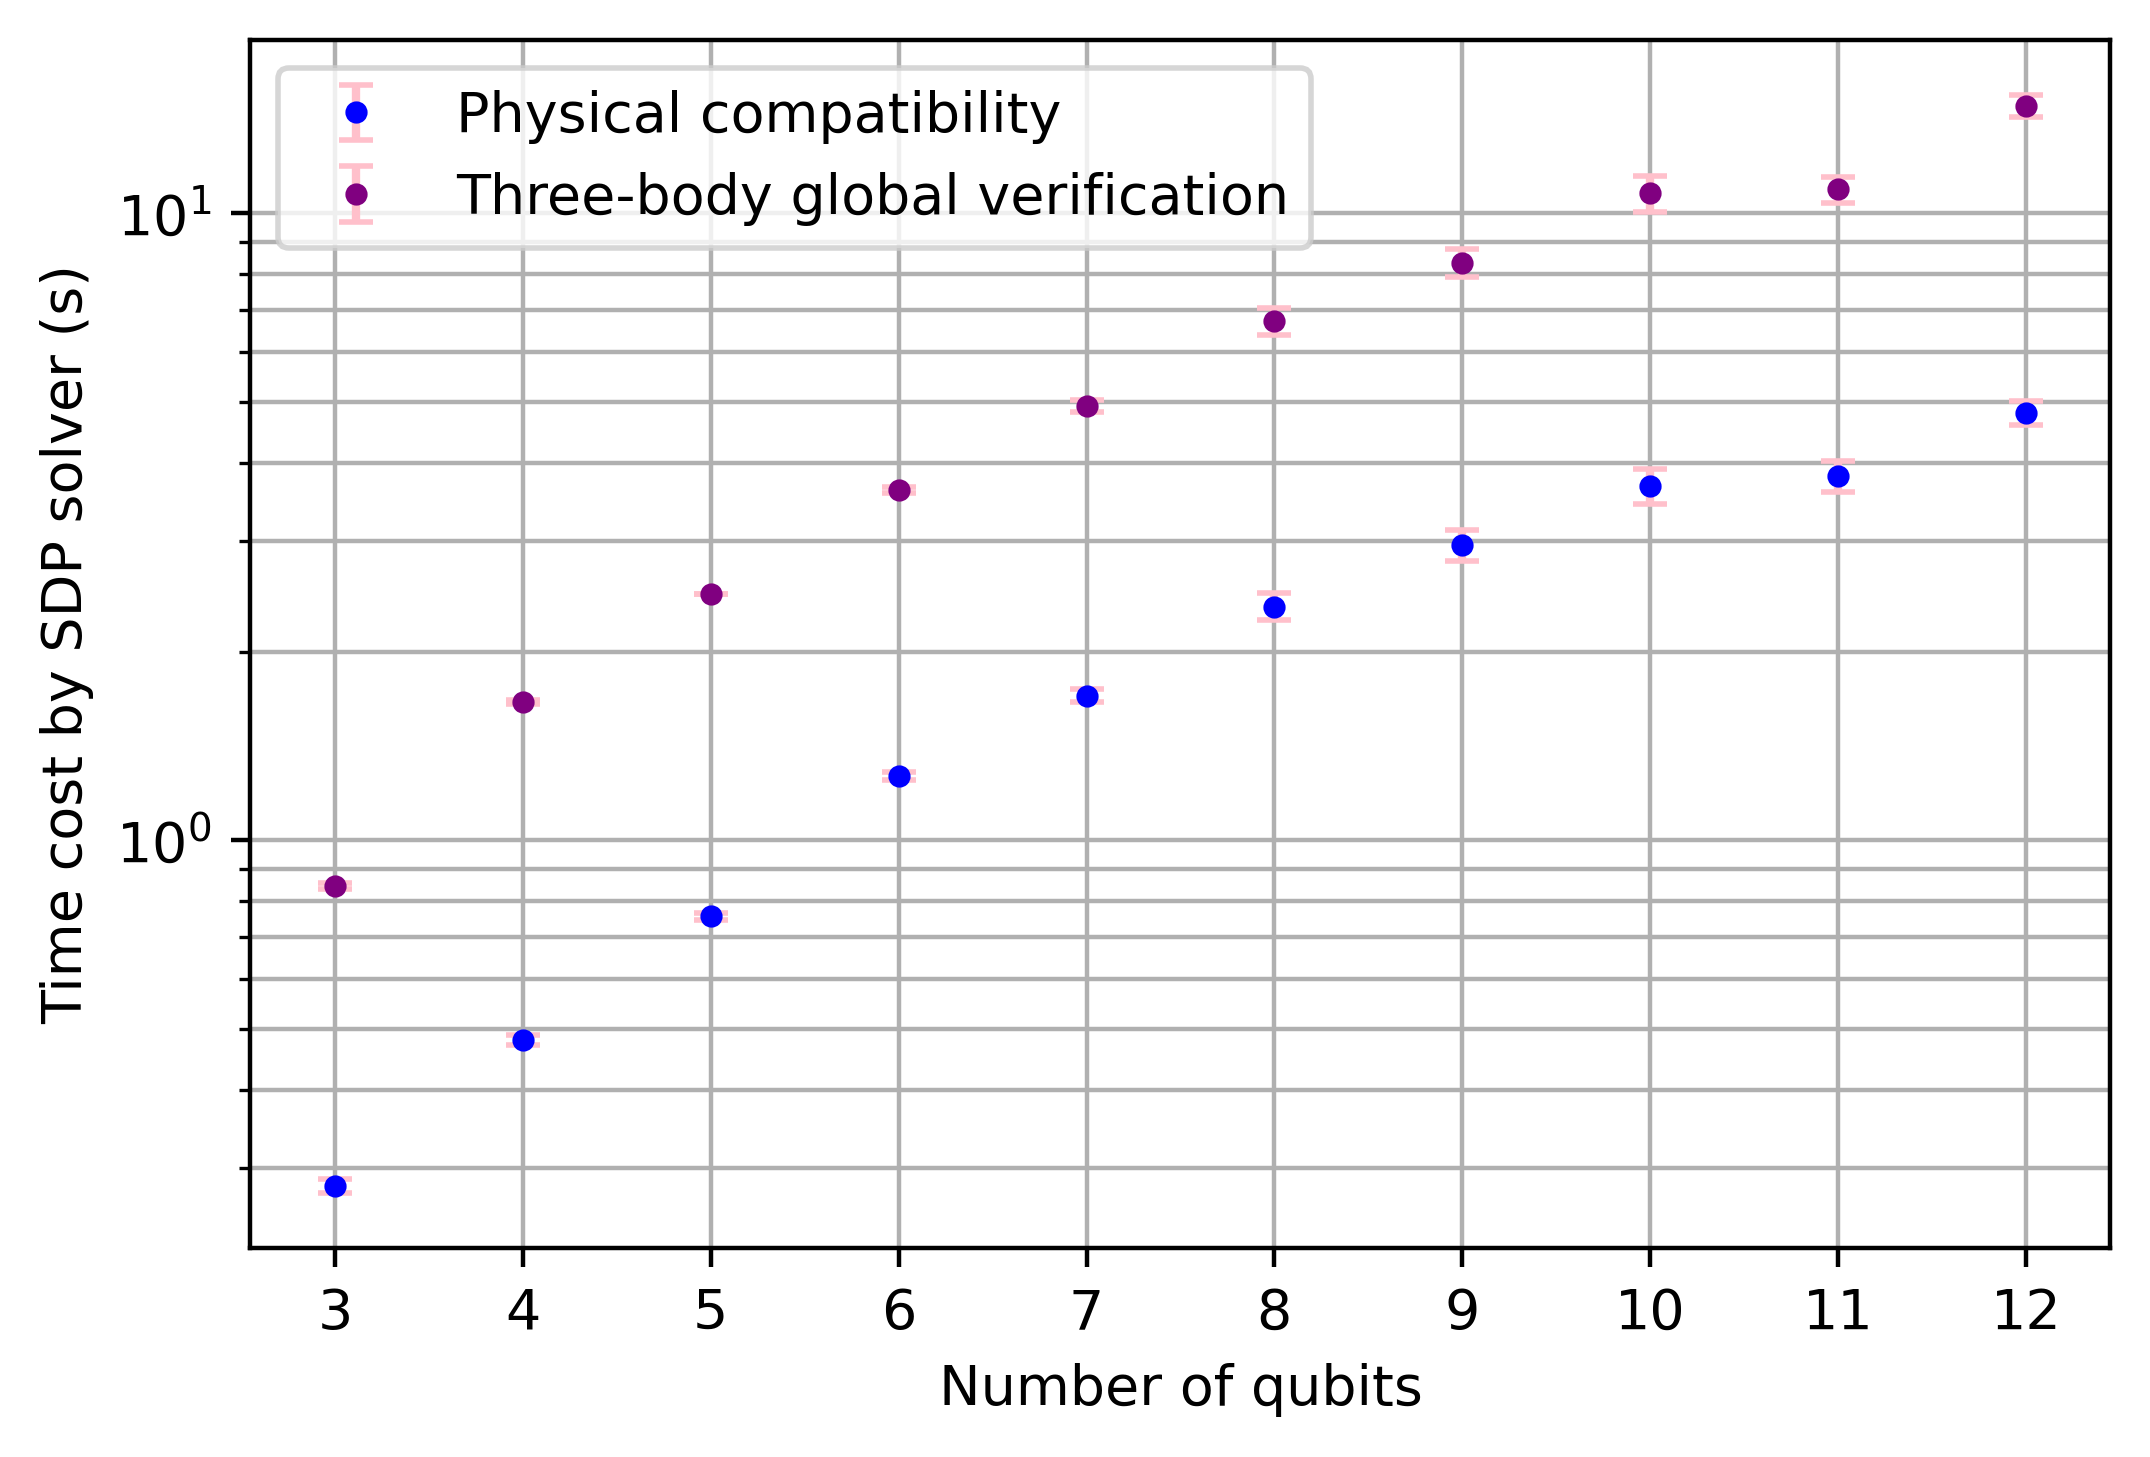

In [6]:
# Import data
N_max = 12
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
N_meas = 2000
num_shots = 80 # Number of shots needed to average the cost of time for each N
name = 'data_complexity'
filename = '%s.npy' % name
data = np.load(filename, allow_pickle=True)
data = data.item()
time_cost_C01 = data['time_cost_C01']
time_std_C01 = data['time_std_C01']
time_cost_C0 = data['time_cost_C0']
time_std_C0 = data['time_std_C0']

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8, 5))
plt.figure(dpi=400)
plt.errorbar(list(range(G, N_max+1)), time_cost_C0, color='blue', yerr=2.58*time_std_C0, ecolor='pink', fmt='o', capsize=3, ms=3, label='Physical compatibility')
plt.errorbar(list(range(G, N_max+1)), time_cost_C01, color='purple', yerr=2.58*time_std_C01, ecolor='pink', fmt='o', capsize=3, ms=3, label='Three-body global verification')

# Set the x-axis to display only integer values
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Number of qubits')
plt.ylabel('Time cost by SDP solver (s)')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-")
figurename = '%s.pdf' % 'complexity'
plt.savefig(figurename)
plt.show()